# Face Mask Segmentation

#Dataset - Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# NOt using google.colab for this project, so not applicable...

In [4]:
import os

path = "C:/Users/idris/Python Workspace" #working directory
os.chdir(path)

In [57]:
import numpy as np
data = np.load('images.npy', allow_pickle=True) #load images

In [6]:
print(data[0,1]) #sample

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


In [50]:
# initializw image dimensions
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [58]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

# creating features & labels

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH)) #masks
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3)) #images
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [9]:
print(X_train.shape)

(409, 224, 224, 3)


In [10]:
print(masks.shape)

(409, 224, 224)


[[[ 0.60000002  0.34117651 -0.20784312]
  [ 0.57647061  0.33333337 -0.17647058]
  [ 0.63137257  0.38823533 -0.11372548]
  ...
  [ 0.49803925  0.53725493  0.56862748]
  [ 0.49019611  0.52941179  0.56078434]
  [ 0.45098042  0.49019611  0.51372552]]

 [[ 0.60784316  0.34901965 -0.19215685]
  [ 0.59215689  0.34901965 -0.1607843 ]
  [ 0.65490198  0.4039216  -0.08235294]
  ...
  [ 0.51372552  0.5529412   0.58431375]
  [ 0.48235297  0.52156866  0.5529412 ]
  [ 0.43529415  0.47450984  0.49803925]]

 [[ 0.62352943  0.36470592 -0.17647058]
  [ 0.60784316  0.36470592 -0.14509803]
  [ 0.67843139  0.42745101 -0.05098039]
  ...
  [ 0.49803925  0.54509807  0.57647061]
  [ 0.47450984  0.52156866  0.54509807]
  [ 0.44313729  0.48235297  0.50588238]]

 ...

 [[ 0.77254903  0.71764708  0.51372552]
  [ 0.74901962  0.67058825  0.45098042]
  [ 0.74117649  0.68627453  0.4666667 ]
  ...
  [-0.63137257 -0.62352943 -0.59215689]
  [-0.63137257 -0.62352943 -0.59215689]
  [-0.6156863  -0.57647061 -0.5529412 ]]

 [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


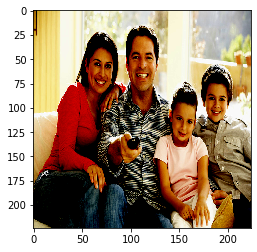

In [11]:
from matplotlib import pyplot

n = 199
print(X_train[n]) #sample image array
pyplot.imshow(X_train[n]) # sample image

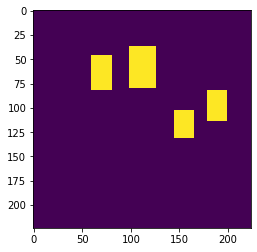

In [40]:
pyplot.imshow(masks[n]) # masks for sample image

In [41]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

#Creating the model
#MobileNet as model with below parameter values
#Add UNET architecture layers

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable

    blockn = model.get_layer("conv_pw_1_relu").output
    
    block0 = model.get_layer("conv_pw_2_relu").output
    
    block1 = model.get_layer("conv_pw_5_relu").output
    
    block2 = model.get_layer("conv_pw_11_relu").output
    
    block3 = model.get_layer("conv_pw_13_relu").output
    

    x = Concatenate()([UpSampling2D()(block3), block2])

    x = Concatenate()([UpSampling2D()(x), block1])

    x = Concatenate()([UpSampling2D()(x), block0])

    x = Concatenate()([UpSampling2D()(x), blockn])
    
    x = UpSampling2D()(x)

    #max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    #y = max_pool_2d(x)
    #z = max_pool_2d(y)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)


    return Model(inputs=model.input, outputs=x)

In [42]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

In [43]:
from tensorflow import reduce_sum
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

#function to calculate dice coefficient
def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

In [44]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
# defining loss metric
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [45]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
#compiling the model using previously defined metrics
optimizer = Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#checkpoint & early stopping
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [35]:
#train the model
model.fit(X_train[0:399],
            masks[0:399],
            batch_size=1,
            epochs=5,
            validation_data=(X_train[400:408],masks[400:408]),
            callbacks=[checkpoint, reduce_lr, stop],
            use_multiprocessing=False,
            shuffle=True,
            verbose=1)

Train on 409 samples, validate on 409 samples
Epoch 1/5
408/409 [============================>.] - ETA: 1s - loss: 1.7646 - dice_coefficient: 0.4919
Epoch 00001: val_loss improved from inf to 1.69082, saving model to model-1.69.h5
409/409 [==============================] - 800s 2s/sample - loss: 1.7661 - dice_coefficient: 0.4914 - val_loss: 1.6908 - val_dice_coefficient: 0.5326
Epoch 2/5
408/409 [============================>.] - ETA: 1s - loss: 1.5992 - dice_coefficient: 0.5401
Epoch 00002: val_loss did not improve from 1.69082
409/409 [==============================] - 791s 2s/sample - loss: 1.6004 - dice_coefficient: 0.5396 - val_loss: 2.0031 - val_dice_coefficient: 0.4820
Epoch 3/5
408/409 [============================>.] - ETA: 26s - loss: 1.5497 - dice_coefficient: 0.5625
Epoch 00003: val_loss did not improve from 1.69082
409/409 [==============================] - 10984s 27s/sample - loss: 1.5489 - dice_coefficient: 0.5628 - val_loss: 1.7251 - val_dice_coefficient: 0.5503
Epoch 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[1.3943145e-12 1.3943145e-12 2.6576362e-13 ... 8.8835368e-06
   1.6174310e-05 1.6174310e-05]
  [1.3943145e-12 1.3943145e-12 2.6576362e-13 ... 8.8835368e-06
   1.6174310e-05 1.6174310e-05]
  [2.2357368e-12 2.2357368e-12 7.2547003e-11 ... 2.5478010e-03
   3.4930526e-05 3.4930526e-05]
  ...
  [2.2312489e-25 2.2312489e-25 8.0090586e-24 ... 8.6249378e-18
   3.3123328e-19 3.3123328e-19]
  [1.8463863e-25 1.8463863e-25 1.2924517e-25 ... 1.6536183e-19
   5.4260613e-19 5.4260613e-19]
  [1.8463863e-25 1.8463863e-25 1.2924517e-25 ... 1.6536183e-19
   5.4260613e-19 5.4260613e-19]]]


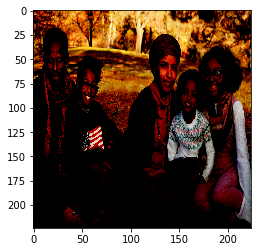

In [59]:
from matplotlib import pyplot as plt

# test sample on trained model
sample_image = X_train[12]

test = np.expand_dims(sample_image, axis=0)

mask = model.predict(test)
print(mask)

plt.imshow(sample_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


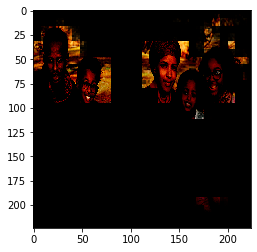

In [60]:
image = sample_image
#Test Results 
image[:,:,0] = mask*image[:,:,0]
image[:,:,1] = mask*image[:,:,1]
image[:,:,2] = mask*image[:,:,2]

out_image = image

plt.imshow(out_image)

In [47]:
# To load trained Model..

WEIGHTS_FILE = "model-1.47.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)